# Machine Learning Portfolio 3

|Name|Github|Kaggle|
|----|------|------|
|Henry Lau|HenryLau08|Henry Lau|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|

## Table of Contents
- [Data Overview](#data-overview)
- [Feature Engineering](#feature-engineering)
- [Modeling](#modeling)
    
- [Results](#results)
    - [Overview](#overview)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, NMF
from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score

pd.set_option('display.max_columns', None)

In [2]:
labeled_path = r"labeled"
unlabeled_path = r"unlabeled"

labeled_files = [os.path.join(labeled_path, file) for file in os.listdir(labeled_path)]
unlabeled_files = [os.path.join(unlabeled_path, file) for file in os.listdir(unlabeled_path)]

In [3]:
def audio_features(files):
    features_list = []

    for file in files:
        
        # Check if it's an audio file (you can expand the condition for specific extensions)
        if file.endswith(('.wav', '.mp3', '.flac')):
            try:
                # Load the audio file
                y, sr = librosa.load(file, sr=None)  # Use original sampling rate

                # Extract features
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # MFCCs
                chroma = librosa.feature.chroma_stft(y=y, sr=sr)  # Chroma features
                spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)  # Spectral contrast

                # Aggregate features (mean and standard deviation)
                feature_vector = {
                    'file_name': os.path.basename(file),
                    'mfccs_mean': np.mean(mfccs, axis=1).tolist(),
                    'mfccs_std': np.std(mfccs, axis=1).tolist(),
                    'chroma_mean': np.mean(chroma, axis=1).tolist(),
                    'spectral_contrast_mean': np.mean(spectral_contrast, axis=1).tolist(),
                }

                features_list.append(feature_vector)
    
            except Exception as e:
                print(f"Error processing {file}: {e}")
    return features_list

labeled_fl = audio_features(labeled_files)
unlabeled_fl = audio_features(unlabeled_files)

In [4]:
labeled_df = pd.DataFrame(labeled_fl).set_index('file_name')
unlabeled_df = pd.DataFrame(unlabeled_fl).set_index('file_name')

In [5]:
# Expand 'mfccs_mean' into multiple columns
mfccs_mean_df = pd.DataFrame(labeled_df['mfccs_mean'].tolist(), index=labeled_df.index, 
                             columns=[f'mfccs_mean_{i}' for i in range(13)])

# Expand 'mfccs_std' into multiple columns
mfccs_std_df = pd.DataFrame(labeled_df['mfccs_std'].tolist(), index=labeled_df.index, 
                            columns=[f'mfccs_std_{i}' for i in range(13)])

# Expand other features similarly
chroma_mean_df = pd.DataFrame(labeled_df['chroma_mean'].tolist(), index=labeled_df.index, 
                              columns=[f'chroma_mean_{i}' for i in range(12)])
spectral_contrast_mean_df = pd.DataFrame(labeled_df['spectral_contrast_mean'].tolist(), 
                                         index=labeled_df.index, 
                                         columns=[f'spectral_contrast_mean_{i}' for i in range(7)])

# Combine all expanded columns into one DataFrame
expanded_features_df = pd.concat([mfccs_mean_df, mfccs_std_df, chroma_mean_df, spectral_contrast_mean_df], axis=1)

# Final labeled DataFrame
final_labeled_df = pd.concat([labeled_df.drop(columns=['mfccs_mean', 'mfccs_std', 'chroma_mean', 'spectral_contrast_mean']), 
                              expanded_features_df], axis=1)

display(final_labeled_df.head())

,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,mfccs_mean_10,mfccs_mean_11,mfccs_mean_12,mfccs_std_0,mfccs_std_1,mfccs_std_2,mfccs_std_3,mfccs_std_4,mfccs_std_5,mfccs_std_6,mfccs_std_7,mfccs_std_8,mfccs_std_9,mfccs_std_10,mfccs_std_11,mfccs_std_12,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6
file_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
m00002.wav,-298.756134,112.076279,6.488818,28.389170,-6.770987,16.645588,-11.807551,12.744363,-8.340971,13.893223,-4.237727,2.317613,-4.329583,39.433178,19.755568,17.913633,10.284375,10.052850,7.867815,9.057553,6.990480,6.884763,8.017497,10.577836,11.242255,10.993814,0.117655,0.133911,0.220483,0.188410,0.168177,0.193637,0.130628,0.203946,0.364396,0.287584,0.224478,0.185700,19.667917,20.515668,26.072390,25.745788,23.396068,19.541724,34.600593
m00039.wav,-169.153351,110.459999,-8.576200,43.884247,0.274970,26.637419,-14.368152,13.034431,-11.149249,8.130109,-7.692966,10.910651,-8.175924,76.763023,34.862965,22.223734,18.106983,15.671126,11.999970,16.115822,11.386265,12.897258,10.966521,10.147038,8.840706,9.594254,0.412044,0.333314,0.389580,0.370359,0.308951,0.386791,0.288708,0.329985,0.243529,0.297682,0.422818,0.401892,19.964829,17.050832,21.109923,19.301231,20.553355,18.597363,38.304349
m00041.wav,-18.845390,71.325661,-3.766896,-1.408727,0.705463,-1.058955,-1.054825,-0.247421,0.625723,0.427043,-1.503742,-1.076155,2.419871,58.091900,22.259552,16.869591,15.726175,11.130232,11.935092,9.296320,9.794338,10.930790,8.955583,9.219586,8.444303,6.864933,0.412797,0.537429,0.301002,0.379488,0.269635,0.380168,0.264904,0.303026,0.473597,0.332073,0.445475,0.293710,17.233862,14.865518,18.241217,18.563320,19.586908,17.007064,15.156099
m00072.wav,-69.630653,83.072273,-16.599928,0.118371,7.420607,0.770008,1.337478,4.695798,-1.416824,3.319435,-2.878265,-8.202150,-5.767511,48.211746,20.987648,17.476086,13.754786,10.223347,10.034362,8.661865,7.707412,8.616606,8.162474,7.835617,8.075592,6.921044,0.286717,0.369671,0.274070,0.371768,0.311118,0.487252,0.551675,0.375336,0.508560,0.282717,0.376277,0.277690,29.752017,16.141935,18.926104,19.113687,19.466281,17.548978,15.208348
m00096.wav,-91.983772,87.640099,-2.066796,34.278149,-18.124571,19.345659,-14.665756,17.112078,-15.336202,17.028185,-13.534051,11.835089,-9.814680,73.534546,22.862232,24.729223,15.726049,15.136001,15.799397,11.942945,12.134771,9.222271,11.038783,12.206540,11.016730,11.804406,0.432902,0.321649,0.366385,0.344440,0.321556,0.335174,0.332990,0.352914,0.269636,0.244928,0.239062,0.318006,16.843315,15.728975,19.023666,19.995101,19.370804,18.633169,43.553926


## Data Overview

In [6]:
labels_new = pd.read_csv('labels_new.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("labeled data")
display(labels_new.head(10))
print()
print("sample submission voor kaggle")
display(sample_submission.head(10))

labeled data


,filename,genre
0,m00248.wav,metal
1,m00230.wav,country
2,m00637.wav,hiphop
3,m00627.wav,metal
4,m00138.wav,reggae
5,m00192.wav,classical
6,m00429.wav,hiphop
7,m00623.wav,reggae
8,m00002.wav,jazz
9,m00039.wav,reggae



sample submission voor kaggle


,filename,genre
0,metal.00032.wav,classical
1,pop.00023.wav,blues
2,classical.00076.wav,blues
3,classical.00021.wav,rock
4,metal.00052.wav,classical
5,classical.00040.wav,reggae
6,pop.00097.wav,hiphop
7,classical.00005.wav,pop
8,classical.00056.wav,pop
9,metal.00073.wav,classical


## Feature Engineering

In [7]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(final_labeled_df)

# Replace original features with scaled ones in a new DataFrame
scaled_df = pd.DataFrame(scaled_features, index=final_labeled_df.index, 
                         columns=final_labeled_df.columns)

display(scaled_df.head())

,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,mfccs_mean_10,mfccs_mean_11,mfccs_mean_12,mfccs_std_0,mfccs_std_1,mfccs_std_2,mfccs_std_3,mfccs_std_4,mfccs_std_5,mfccs_std_6,mfccs_std_7,mfccs_std_8,mfccs_std_9,mfccs_std_10,mfccs_std_11,mfccs_std_12,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6
file_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
m00002.wav,-1.498492,0.463125,0.935340,-0.414501,-0.456621,0.172973,-0.548461,0.153939,-0.153653,0.691429,0.192370,-0.480569,0.140689,-0.704794,-0.469806,-0.286939,-0.814536,-0.633493,-0.807563,-0.338407,-0.911980,-0.917610,-0.154411,1.108806,1.725179,1.458229,-2.539571,-1.928496,-1.423524,-1.609053,-1.953086,-2.058153,-1.838270,-1.600331,-0.212085,-0.847004,-1.228582,-1.798193,-0.357985,1.924882,2.133247,2.261729,1.608506,0.527621,0.437552
m00039.wav,-0.211600,0.404914,0.229862,0.415860,0.081080,1.094913,-0.799305,0.183916,-0.491156,-0.023165,-0.324015,0.721317,-0.430791,1.228443,1.686778,0.326579,1.292470,0.966229,0.774582,2.460424,1.339683,2.429244,1.629450,0.897467,0.475017,0.789752,0.273033,-0.295538,-0.064504,-0.136001,-0.824791,-0.139264,-0.651897,-0.559362,-1.114390,-0.773176,0.166658,0.148347,-0.281627,0.510023,0.549347,0.044033,0.522903,0.042418,0.757910
m00041.wav,1.280884,-1.004524,0.455077,-2.011332,0.113932,-1.460614,0.504906,-1.188670,0.923977,-0.978301,0.600964,-0.955247,1.143507,0.261504,-0.112362,-0.435552,0.651203,-0.326724,0.749740,-0.243728,0.524247,1.334610,0.413036,0.442482,0.268663,-0.513862,0.280229,1.376010,-0.776397,-0.062087,-1.139908,-0.205061,-0.830546,-0.782019,0.603137,-0.521752,0.326042,-0.825697,-0.983958,-0.382345,-0.366275,-0.209896,0.153827,-0.774660,-1.244305
m00072.wav,0.776611,-0.581466,-0.145880,-1.929497,0.626388,-1.291856,0.739263,-0.677823,0.678501,-0.619661,0.395541,-1.951941,-0.072955,-0.250169,-0.293926,-0.349221,0.120213,-0.584946,0.021977,-0.495310,-0.544745,0.046420,-0.066715,-0.236460,0.076726,-0.487062,-0.924345,0.002195,-0.992849,-0.124589,-0.807427,0.858760,1.321635,-0.184796,0.864143,-0.882585,-0.160740,-0.969936,2.235373,0.138877,-0.147676,-0.020504,0.107761,-0.496231,-1.239786
m00096.wav,0.554656,-0.416954,0.534690,-0.098918,-1.323052,0.422107,-0.828459,0.605312,-0.994350,1.080146,-1.196965,0.850616,-0.674273,1.061247,-0.026329,0.683221,0.651169,0.813860,2.229329,0.805744,1.723092,0.383563,1.673161,1.907809,1.607778,1.845394,0.472309,-0.391065,-0.250915,-0.345838,-0.723767,-0.652051,-0.319566,-0.369985,-0.919499,-1.158851,-1.125989,-0.606942,-1.084396,-0.029755,-0.116537,0.282807,0.071299,0.060815,1.211974


## Modeling

In [ ]:
labeled_data = 1    #set the data
unlabeled_data = 2  #set the data

In [12]:
def plot_elbow(data, r=range(1,11)):
    wcss = []  # Within-cluster sum of squares
    for k in r:  # Try k values from 1 to 10
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(r, wcss, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS')
    plt.show()

def plot_dendrogram(data):
    # Compute the linkage matrix
    linkage_matrix = linkage(data, method='ward')

    plt.figure(figsize=(10, 6))
    dendrogram(
        linkage_matrix,
        leaf_rotation=90,  # Rotates x-axis labels
        leaf_font_size=10,  # Font size for x-axis labels
        color_threshold=1.5,  # Set the color threshold for clusters
    )
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()

def plot_tsne(data):
    plt.figure(figsize=(8, 6))
    plt.scatter(data['t-SNE1'], data['t-SNE2'], s=50, c='blue', alpha=0.7)
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()


### K-Means Clustering

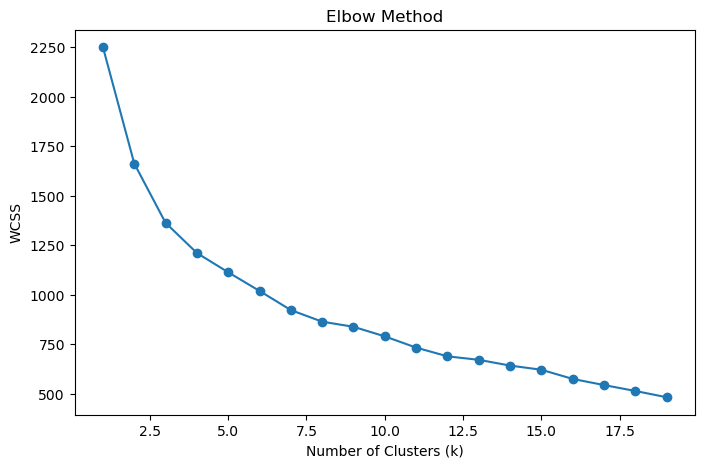

In [14]:
plot_elbow(unlabeled_data, r=range(1,20))

In [ ]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(unlabeled_data)
labels = kmeans.predict(unlabeled_data)
unlabeled_data['kmeans'] = labels
sns.countplot(data=unlabeled_data, x=unlabeled_data['kmeans'])
plt.show()

### Hierarchical Clustering

In [9]:
# Compute the linkage matrix
linkage_matrix = linkage(unlabeled_data, method='ward')

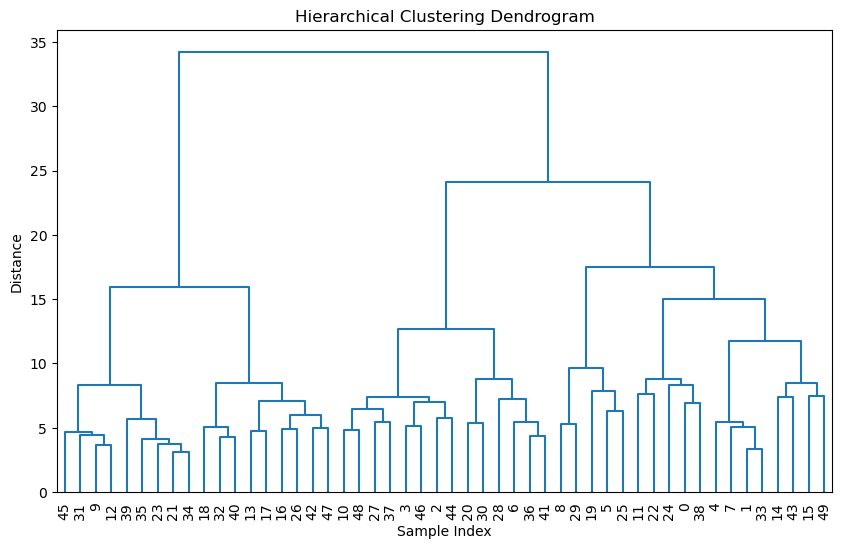

In [10]:
plt.figure(figsize=(10, 6))
dendrogram(
    linkage_matrix,
    leaf_rotation=90,  # Rotates x-axis labels
    leaf_font_size=10,  # Font size for x-axis labels
    color_threshold=1.5,  # Set the color threshold for clusters
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


In [ ]:
# Assign cluster labels (specify the number of clusters)
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add cluster labels to the DataFrame
unlabeled_data['HC'] = cluster_labels
print(unlabeled_data)

### T-SNE

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(unlabeled_data)

# Add t-SNE results to the DataFrame
unlabeled_data['t-SNE1'] = tsne_results[:, 0]
unlabeled_data['t-SNE2'] = tsne_results[:, 1]

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(unlabeled_data['t-SNE1'], unlabeled_data['t-SNE2'], s=50, c='blue', alpha=0.7)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

### Principal Component Analysis (PCA)

In [ ]:
pca = PCA(n_components=2)  # Reduce to 2 components
pca_results = pca.fit_transform(unlabeled_data)

# Add PCA results to DataFrame
pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])

In [ ]:
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c='blue', s=50, alpha=0.7)
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(pca_df.drop('genre', axis=1))
labels = kmeans.predict(pca_df)
pca_df['kmeans'] = labels
sns.countplot(data=pca_df, x=pca_df['kmeans'])
plt.show()

In [ ]:
# Compute the linkage matrix
linkage_matrix = linkage(pca_df, method='ward')

In [ ]:
plt.figure(figsize=(10, 6))
dendrogram(
    linkage_matrix,
    leaf_rotation=90,  # Rotates x-axis labels
    leaf_font_size=10,  # Font size for x-axis labels
    color_threshold=1.5,  # Set the color threshold for clusters
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(pca_df)

# Add t-SNE results to the DataFrame
pca_df['t-SNE1'] = tsne_results[:, 0]
pca_df['t-SNE2'] = tsne_results[:, 1]

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['t-SNE1'], pca_df['t-SNE2'], s=50, c='blue', alpha=0.7)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

### Non-Negative Matrix Factorization (NMF)

In [ ]:
data_non_negative = np.abs(unlabeled_data.values)  # Ensure all values are non-negative

# Apply NMF
nmf = NMF(n_components=2, random_state=42)
nmf_features = nmf.fit_transform(data_non_negative)

# Add NMF features to DataFrame
nmf_df = pd.DataFrame(nmf_features, columns=['NMF1', 'NMF2'])

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(nmf_df['NMF1'], nmf_df['NMF2'], c='green', s=50, alpha=0.7)
plt.title('NMF Visualization')
plt.xlabel('NMF Component 1')
plt.ylabel('NMF Component 2')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(nmf_df.drop('genre', axis=1))
labels = kmeans.predict(nmf_df)
nmf_df['kmeans'] = labels
sns.countplot(data=nmf_df, x=nmf_df['kmeans'])
plt.show()

In [ ]:
# Compute the linkage matrix
linkage_matrix = linkage(nmf_df, method='ward')

In [ ]:
plt.figure(figsize=(10, 6))
dendrogram(
    linkage_matrix,
    leaf_rotation=90,  # Rotates x-axis labels
    leaf_font_size=10,  # Font size for x-axis labels
    color_threshold=1.5,  # Set the color threshold for clusters
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(nmf_df)

# Add t-SNE results to the DataFrame
nmf_df['t-SNE1'] = tsne_results[:, 0]
nmf_df['t-SNE2'] = tsne_results[:, 1]

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(nmf_df['t-SNE1'], nmf_df['t-SNE2'], s=50, c='blue', alpha=0.7)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

## Results

## Conclusion & Advice

## Sources